# 0.) Load libraries/datasets

In [1]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from itertools import product
from os.path import isdir, isfile

import librosa
import librosa.display

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.model_selection import  cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier as KNN

import torch
import torch.nn as nn

# Set up datapath
base_path = './datasets/petsounds/cats_dogs/'

if not isdir(base_path):
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")

# Lambda to construct full path to cat/dog files
route = lambda x: base_path + x    
    
# Get dictionary of sounds
cat_file = 'cat_{}.wav'
dog_file = 'dog_barking_{}.wav'

pet_sounds = {'cat': [], 'dog': []}
for i in range(0, 168):
    this_cat = cat_file.format(i)
    
    if isfile(route(this_cat)):
        pet_sounds['cat'].append(this_cat)
        
    this_dog = dog_file.format(i)
    if isfile(route(this_dog)):
        pet_sounds['dog'].append(this_dog)

# 1.) Pre-process a single file using 20 frequency bins, and 2000 Hz sampling frequency.

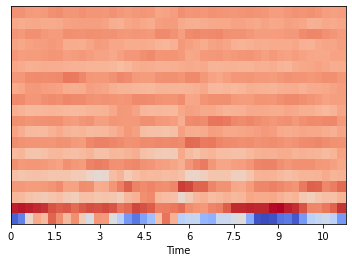

In [2]:
SAMPLING_FRQ = 2000
BINS = 20

# Process the first cat file
x, fs = librosa.load(base_path + pet_sounds['cat'][0], sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

# 2.) Process each into X and Y matrices. Apply a classifier and comment on results.

### Some setup

In [3]:
# Up sampling frequency to 4k
SAMPLING_FRQ = 4000

# Set the FFT length; this leads to better sklearn accuracy and 
#     prevents warnings about frame size.
# https://librosa.org/doc/main/ioformats.html?highlight=n_fft
# https://librosa.org/doc/main/glossary.html?highlight=n_fft
FFT = (2048 * SAMPLING_FRQ) // 22050

# Generator function to get all dogs/cats files and label
def get_pet(ps_dict=pet_sounds):
    for pet in ['cat', 'dog']:
        for i in range(0, len(ps_dict[pet])):
            yield(ps_dict[pet][i], pet)
        
    return None

# Function to format a scores array into a string for clean output
def score_string(scores):
    score_str = ''
    for idx, score in enumerate(scores):
        score_str += f'{score:.3f}'

        if idx < len(scores)-1:
            score_str += ', '
    return score_str

### Convert each file into a waveform and store to DataFrame

Storing to the DataFrame is overkill, but it kept my accustomed workflow uniform.

In [4]:
%%time
# Setup dict for conversion to dataframe
mfcc_dict = {}

for i in range(0, BINS):
    mfcc_dict[f'MFCC_{i}'] = []
    
mfcc_dict['class'] = []
mfcc_dict['file'] = []

# Begin processing
for file, pet in get_pet():
    # Load waveform and then MFCCs
    wf, sr = librosa.load(route(file), sr=SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(wf, sr=sr, n_mfcc=BINS,  n_fft=FFT)
    
    # Add the mfccs values to the dict
    for i in range(len(mfccs)):
        mfcc_dict[f'MFCC_{i}'] += list(mfccs[i])
        
    # Add the class and file data to the dict
    mfcc_dict['class'] += [pet] * len(mfccs[0])
    mfcc_dict['file'] += [file] * len(mfccs[0])
    
# Create df
ps_df = pd.DataFrame(mfcc_dict)  
display(ps_df.head())

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,class,file
0,-401.809357,-6.883381,37.074257,8.628761,-29.159145,8.689097,-18.552784,9.624913,7.769758,-2.060371,...,-4.356100,21.479511,-0.473684,9.695920,-4.573258,6.906791,-5.868635,6.419685,cat,cat_1.wav
1,-451.546722,71.212662,9.399033,1.004311,-21.921337,-6.178900,-17.028160,-3.420985,-9.570549,5.378979,...,1.343737,15.090796,-5.538236,0.010957,-16.734739,-3.696348,-1.431490,0.020052,cat,cat_1.wav
2,-467.586639,66.741180,-3.497696,-1.904689,-12.276022,-3.175431,-26.669401,9.023046,-14.347547,1.665917,...,-5.439006,12.779629,-7.836804,-1.615032,-14.847106,-4.164678,-6.856385,5.027203,cat,cat_1.wav
3,-462.881042,73.702545,1.519370,0.349248,-28.249584,-11.111387,-18.216236,-1.470416,-10.215891,3.547067,...,-2.649648,16.240955,0.552022,-1.608632,-11.360909,-7.012007,-4.216261,7.969718,cat,cat_1.wav
4,-432.400360,83.312820,11.399536,10.474149,-14.801990,2.420839,-21.404341,8.065123,-16.961800,6.195270,...,-7.925519,8.626961,-0.748905,1.306565,-19.525753,-9.941595,-4.196818,6.096716,cat,cat_1.wav


Wall time: 21.6 s


In [11]:
# Split the data into X and Y
def split(df):
    X_filter = [col for col in df.columns if col not in ['file', 'class']]
    X = df.loc[:, X_filter].values

    Y_binarize = lambda pet: 0 if pet == 'cat' else 1
    Y = df.loc[:, 'class']
    Y = Y.apply(Y_binarize)
    Y = Y.values
    
    return X, Y

X, Y = split(ps_df)
print(X.shape, Y.shape)

(277, 20) (277,)


### Do some sklearn

Parameters for SVC were found through GridSearchCV, but it took 2 hours and I was mad the results favoured SVC so I deleted it. Luckily, this cell doesn't take too long (about 30 seconds).

For reference, I also tried RandomForestClassifier and K-Nearest Neighbors, both of which performed similarly but worse.

Stratified K-Fold vs regualar K-Fold seems to not change the outcomes very much here (expected due to class balance). 
Shuffling the K-Fold improves the scores by about 5% in either K-Fold variety.

In [6]:
%%time

# Run cross-validation
model = SVC(C=10, kernel='poly') 
kfold = StratifiedKFold(n_splits=10, shuffle=True) 

sk_scores = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')

# Display scores and statistics
print(f'Model: {model}')
print(f'\tScores: {score_string(sk_scores)}')
print(f'\tMean: {np.mean(sk_scores):.4f}')
print(f'\tSTD: {np.std(sk_scores):.4f}\n')

Model: SVC(C=10, kernel='poly')
	Scores: 0.871, 0.873, 0.862, 0.878, 0.878, 0.873, 0.858, 0.878, 0.884, 0.874
	Mean: 0.8729
	STD: 0.0074

Wall time: 35.5 s


# 3.) Use an RNN to classify and compare results with the model above.

### Prepare dataset

The code here is a copy-paste-modify from part 2.

In [13]:
%%time
# Setup dict for conversion to dataframe
mfcc_dict = {}

for i in range(0, BINS):
    mfcc_dict[f'MFCC_{i}'] = []
    
mfcc_dict['class'] = []
mfcc_dict['file'] = []

# Begin processing
for file, pet in get_pet():
    # Load waveform and then MFCCs
    wf, sr = librosa.load(route(file), sr=SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(wf, sr=sr, n_mfcc=BINS,  n_fft=FFT)
    
    for i in range(len(mfccs)):
        mfcc_dict[f'MFCC_{i}'].append(mfccs[i])
    
    # Add the class and file data to the dict
    mfcc_dict['class'] += [pet]
    mfcc_dict['file'] += [file]
    
# Create df
ps_df2 = pd.DataFrame(mfcc_dict)  
display(ps_df2.head())

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,class,file
0,"[-401.80936, -451.54672, -467.58664, -462.8810...","[-6.883381, 71.21266, 66.74118, 73.702545, 83....","[37.074257, 9.399033, -3.4976964, 1.5193703, 1...","[8.628761, 1.0043112, -1.9046891, 0.34924823, ...","[-29.159145, -21.921337, -12.276022, -28.24958...","[8.689097, -6.1789, -3.1754315, -11.111387, 2....","[-18.552784, -17.02816, -26.669401, -18.216236...","[9.624913, -3.4209855, 9.0230465, -1.470416, 8...","[7.7697577, -9.570549, -14.347547, -10.215891,...","[-2.0603714, 5.3789787, 1.665917, 3.5470674, 6...",...,"[-4.3560996, 1.3437372, -5.439006, -2.6496482,...","[21.479511, 15.0907955, 12.779629, 16.240955, ...","[-0.47368369, -5.5382357, -7.8368044, 0.552021...","[9.69592, 0.010957241, -1.6150316, -1.6086321,...","[-4.5732584, -16.73474, -14.847106, -11.360909...","[6.9067907, -3.6963482, -4.1646776, -7.0120068...","[-5.868635, -1.4314901, -6.8563848, -4.2162614...","[6.4196854, 0.020051628, 5.0272026, 7.9697185,...",cat,cat_1.wav
1,"[-344.2184, -284.23294, -355.02216, -298.8089,...","[95.51453, -20.22776, 5.0465946, -20.815567, -...","[1.4991984, 16.654938, -2.141654, 6.4543886, 1...","[-11.321596, 13.3414135, -0.4808802, -3.375414...","[-9.563206, -36.605118, -6.6094084, -29.65116,...","[-4.035137, -16.219778, 28.721008, 20.543663, ...","[-7.3859787, 75.392265, -17.691341, 68.08554, ...","[-7.092778, 15.256916, -23.772314, -66.43727, ...","[-9.239674, -61.949028, -10.483177, -21.274479...","[12.52318, 0.35393, 28.837105, 20.083591, -26....",...,"[3.7083015, -8.133358, 12.401703, -1.8083338, ...","[-8.360416, 20.652275, 13.069342, 9.380187, 2....","[2.1641316, 0.7270795, 4.7709284, -22.195827, ...","[-0.575918, -35.13061, -7.6063776, 4.17298, 9....","[8.891575, -7.3293247, -4.7792177, -15.78343, ...","[-9.253698, -2.0957146, 18.818874, 25.894243, ...","[1.7999182, -5.010973, -9.974331, -18.792809, ...","[-10.668451, 15.476085, 9.985807, 2.6533046, -...",cat,cat_2.wav
2,"[-403.47443, -448.5414, -471.86935, -453.12863...","[108.62535, 90.02361, 69.99269, 90.98558, 71.3...","[4.085188, 7.573201, 3.1570623, 15.355835, 7.4...","[2.4409094, 19.754894, 8.338892, 29.29024, 10....","[1.7462524, 2.685588, -11.754992, -6.17817, -3...","[3.4148088, 18.032787, -3.950335, 12.409147, 8...","[7.220293, -6.1974688, -12.242647, -0.88064736...","[-28.264847, -1.9417651, 3.3925636, 0.54625416...","[-21.582455, -19.583693, -15.467732, -4.311661...","[-12.913676, -6.1094637, -12.028267, 4.68273, ...",...,"[-18.94793, -9.235094, 6.44123, -5.31863, -1.5...","[-11.342417, 9.480811, 13.627119, 20.934246, 1...","[-4.480503, 1.1816481, -5.6531334, -18.485214,...","[-9.215339, -2.8139315, 7.62663, -2.4615538, 1...","[-1.6990798, -7.2358837, -5.894868, -6.5509553...","[-0.049087375, -1.3047061, 9.434969, 8.064777,...","[-4.867521, -8.903901, -4.7318935, -9.318604, ...","[-8.416124, 6.6811743, -7.3370667, 1.4091848, ...",cat,cat_3.wav
3,"[-673.86945, -387.8128, -238.494, -299.30484, ...","[0.0, 82.536194, -1.1008749, 45.082203, -8.911...","[0.0, 20.923443, -21.099197, 7.210664, 43.5647...","[0.0, 22.798866, 17.61157, 6.664649, -5.191034...","[0.0, -12.134071, 22.821392, 14.1772375, -1.01...","[0.0, 7.314184, 9.904578, 13.392807, -10.27915...","[0.0, -18.468218, -4.404189, 71.1211, 82.43952...","[0.0, 3.2264261, 1.9280645, -79.090225, -56.56...","[0.0, -15.537003, -34.319252, 28.024986, -7.80...","[0.0, -3.245573, -1.0997157, -32.4795, 13.9071...",...,"[0.0, -13.6087885, -18.369, -20.228151, -8.813...","[0.0, 8.881754, -9.155796, 2.6402764, 8.14586,...","[0.0, -2.843861, -8.153879, -17.5074, -31.6195...","[0.0, 3.192822, 17.350632, -1.6908722, -2.6428...","[0.0, 1.8992742, 10.190598, 38.403763, 0.49443...","[0.0, 9.689297, 4.188316, -5.091464, 37.233498...","[0.0, 3.370636, -1.4079533, -28.16678, -39.113...","[0.0, 3.578201, 13.7723465, 15.517822, 18.6623...",cat,cat_4.wav
4,"[-764.5576, -513.7193, 

Wall time: 21.4 s


### Model definition

In [17]:
class RNN(nn.Module):
    def __init__(self, n_features, n_hidden, n_output, eta=0.0005):
        super(RNN, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden

        self.i2h = nn.Linear(n_features + n_hidden, n_hidden)
        self.i2o = nn.Linear(n_features + n_hidden, n_output)
        self.softmax = nn.LogSoftmax(dim=1)

        self.eta = eta  # learning rate
        
        self.epochs = 50
        self.batch_size = 1000
        
        # loss function, since the last layer is nn.LogSoftmax
        self.criterion = nn.NLLLoss()

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.n_hidden)
    
    def predict(self, sxx):
        y_pred = []
        with torch.no_grad():
            hidden = self.init_hidden()
            sxx = torch.tensor(sxx, dtype=torch.float)
            for i in range(sxx.shape[0]):
                output, hidden = self.forward(sxx[i].reshape(1,self.n_features), hidden)
                y_pred.append(0 if output[0][0]>output[0][1] else 1)
            
        return y_pred

    def train(self, sxx, y):
        # Allow for conversions to tensor if necessary (it is)
        if type(sxx) != type(torch.tensor):
            sxx = torch.tensor(sxx)
        if type(y) != type(torch.tensor):
            y = torch.tensor(y, dtype=torch.long)
            
        
        
        # Run data through
        for epo in range(self.epochs):
            N = sxx.shape[0]
            
            self.zero_grad()
            hidden = self.init_hidden()
            
            for idx in range(0, N - self.batch_size + 1, self.batch_size):
                jdx = idx + self.batch_size
                
                print(epo, idx, jdx)
                
                for i in range(idx, jdx):
                    output, hidden = self.forward(sxx[i].reshape(1,self.n_features), hidden)
                    target = y[i].reshape(1,)

                    # Generate loss and apply backprop for batch
                    loss = self.criterion(output, target)
                    loss.backward(retain_graph=True)

                for p in self.parameters():
                    p.data.add_(-self.eta, p.grad.data)

        return output, loss.item()

### Do some RNN

In [18]:
# Split the data into X and Y
X, Y = split(ps_df2)

print(X.shape, Y.shape)

(277, 20) (277,)


In [19]:
# Run a 10-fold CV w/ RNN
scores = []
for train_idx, test_idx in kfold.split(X, Y):
    # Get Splits
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    print(len(X), len(Y))
    # Declare our RNN
    rnn = RNN(BINS, 15, 2)
    
    # Train
    rnn.train(x_train, y_train)

    # Test and score
    y_pred = rnn.predict(x_test)
    score = ~(y_pred ^ y_test)
    score = [0 if i == False else 1 for i in score]
    score = score / len(y_test)
    scores.append(score)
    
    break

277 277


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
torch.cuda.is_available()
